In [1]:
from constants import *
from datasets import load_dataset
from collections import defaultdict
import json
import re
import ast
import metrics
from constants import *
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/jmire/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download gold references
ds = load_dataset(AOKVQA_DATASET_NAME)
splits = ['validation']
for split in splits:
    gold_df = defaultdict(dict)
    for ex in ds[split]:
        gold_df[ex['question_id']] = {
            'mc': ex['choices'][ex['correct_choice_idx']],
            'da': ast.literal_eval(ex['direct_answers'])
        }

    with open(f'{RESULTS_DIR}/gold_{split}.jsonl', "w") as f:
      for key, value in gold_df.items():
          json_line = json.dumps({key: value})
          f.write(json_line + "\n")

qid_to_mc_choices = {}
for ex in ds['validation']:
  qid_to_mc_choices[ex['question_id']] = ex['choices']

In [3]:
# Process raw result files into standard format

def joel_fmt(fname):
    input_file = f'{RESULTS_DIR}/raw/joel/{fname}'
    output_file = f"{RESULTS_DIR}/formatted/{fname.replace('.json', '')}.jsonl"
    with open(input_file, 'r') as f, open(output_file, 'w') as out_f:
        data = json.load(f)
        for id, entry in data.items():
            record = {
                "qid": id,
                "da": entry.get('direct_answer'),
                "mc": entry.get('multiple_choice')
            }
            out_f.write(json.dumps(record) + '\n')

def nihali_fmt(fname):
  records = []
  out_dict = defaultdict(lambda: defaultdict(str))
  for task in ['da', 'mc']:
    for result in ['correct', 'incorrect']:
      input_file = f'{RESULTS_DIR}/raw/nihali/{fname}_{task}_{result}.json'
      with open(input_file, 'r') as f:
        data = json.load(f)
        for qid, entry in data.items():
          out_dict[qid]['qid'] = qid
          out_dict[qid][task] = entry.get('prediction')

  for qid, val in out_dict.items():
    record = {
      "qid": val['qid'],
      "da": val['da'],
      "mc": val['mc']
    }
    records.append(record)

  output_file = f"{RESULTS_DIR}/formatted/{fname}.jsonl"
  with open(output_file, 'w') as out_f:
    for record in records:
      out_f.write(json.dumps(record) + '\n')

def mingqian_fmt(fname):
  records = []
  da_input_file = f'{RESULTS_DIR}/raw/mingqian/{fname}_da.json'
  mc_input_file = f'{RESULTS_DIR}/raw/mingqian/{fname}_mc.json'
  with open(da_input_file, 'r') as da_f, open(mc_input_file, 'r') as mc_f:
    da_data = json.load(da_f)
    mc_data = json.load(mc_f)
    for da_entry, mc_entry in zip(da_data, mc_data):
      qid = da_entry['question_id']
      match = re.search(r'\d+', mc_entry['answer'])
      mc_choice_idx = int(match.group()) - 1 if match else None
      record = {
        "qid": qid,
        "da": da_entry['answer'],
        "mc": qid_to_mc_choices[qid][mc_choice_idx] if mc_choice_idx is not None and 0 <= mc_choice_idx <= 3 else ""
      }
      records.append(record)
  output_file = f"{RESULTS_DIR}/formatted/{fname}.jsonl"
  with open(output_file, 'w') as out_f:
    for record in records:
      out_f.write(json.dumps(record) + '\n')

for model, val in MODELS.items():
  dir = val['raw_results_dir']
  fname = val['raw_results_fname']
  if dir == 'joel':
    joel_fmt(fname)
  elif dir == 'nihali':
    nihali_fmt(fname)
  elif dir == 'mingqian':
    mingqian_fmt(fname)

mc


                      model task      bleu  bertscore    mc_acc
0           BLIP 2 OPT 2.7B   mc  0.475547   0.599098  0.214847
1                  ViperGPT   mc  0.042435   0.693287  0.408734
2              LLaVA-1.5-7b   mc  0.823578   0.850772  0.690830
3       CLIP (Zero Shot) MM   mc  0.048162   0.413909  0.000873
4     CLIP (Contrastive) MM   mc  0.070877   0.413713  0.004367
5      CLIP (Classifier) MM   mc  0.078155   0.420114  0.006987
6                   ClipCap   mc  0.036345   0.411337  0.000000
7     ClipCap (with RN50x4)   mc  0.075810   0.414838  0.003493
8       Llama 3 8B Instruct   mc  0.004314   0.597999  0.212227
9   CLIP (Contrastive) UM-T   mc  0.073021   0.417486  0.004367
10   CLIP (Classifier) UM-T   mc  0.087676   0.420361  0.007860
11          BERT Classifier   mc  0.076851   0.422370  0.007860
12    CLIP (Zero Shot) UM-I   mc  0.052945   0.413402  0.004367
13  CLIP (Contrastive) UM-I   mc  0.052945   0.413402  0.004367
14   CLIP (Classifier) UM-I   mc  0.0745

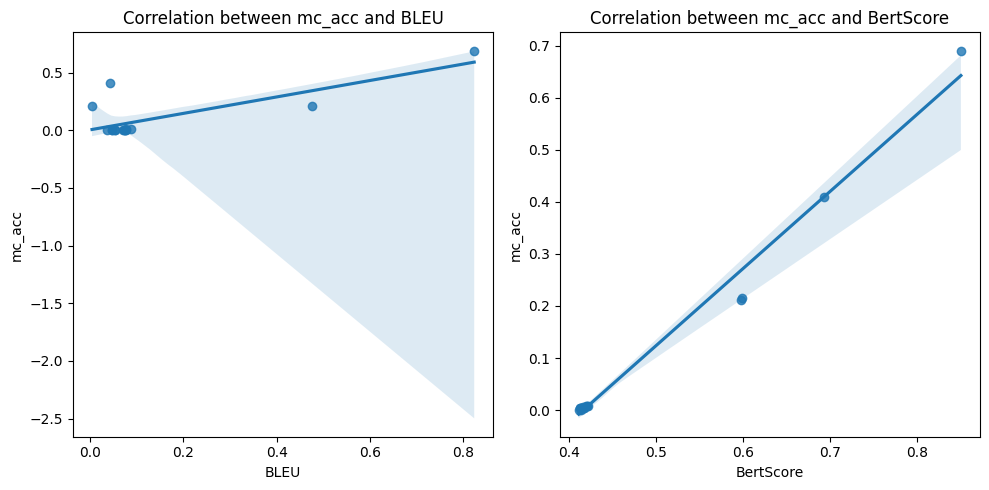

da


                      model task      bleu  bertscore    da_acc
0           BLIP 2 OPT 2.7B   da  0.016196   0.291609  0.060844
1                  ViperGPT   da  0.010567   0.646888  0.208151
2              LLaVA-1.5-7b   da  0.216836   0.883225  0.581077
3       CLIP (Zero Shot) MM   da  0.057781   0.428240  0.000582
4     CLIP (Contrastive) MM   da  0.061088   0.425326  0.000000
5      CLIP (Classifier) MM   da  0.120623   0.470154  0.005531
6                   ClipCap   da  0.035109   0.443256  0.000873
7     ClipCap (with RN50x4)   da  0.078541   0.452031  0.002329
8       Llama 3 8B Instruct   da  0.000979   0.530229  0.085007
9   CLIP (Contrastive) UM-T   da  0.048049   0.424382  0.000000
10   CLIP (Classifier) UM-T   da  0.089874   0.462322  0.001164
11          BERT Classifier   da  0.064766   0.451106  0.000000
12    CLIP (Zero Shot) UM-I   da  0.051246   0.418767  0.000000
13  CLIP (Contrastive) UM-I   da  0.051246   0.418767  0.000000
14   CLIP (Classifier) UM-I   da  0.1098

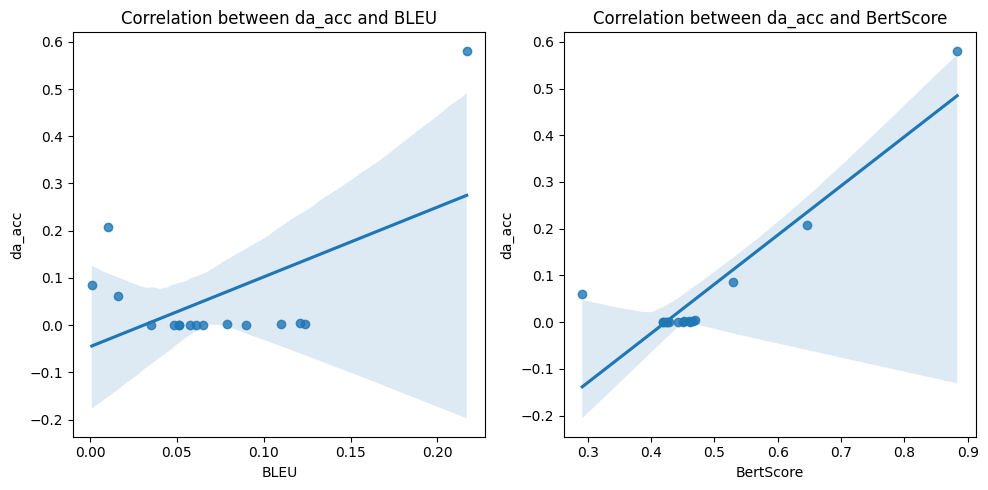

In [4]:
def format_string(s):
    # Convert to lowercase
    s = s.lower()
    
    # Remove punctuation
    s = re.sub(r'[^\w\s]', '', s)
    
    # Remove articles (a, an, the)
    s = re.sub(r'\b(a|an|the)\b', '', s)
    
    # Convert words to digits (if they are numbers)
    s = re.sub(r'\bzero\b', '0', s)
    s = re.sub(r'\bone\b', '1', s)
    s = re.sub(r'\btwo\b', '2', s)
    s = re.sub(r'\bthree\b', '3', s)
    s = re.sub(r'\bfour\b', '4', s)
    s = re.sub(r'\bfive\b', '5', s)
    s = re.sub(r'\bsix\b', '6', s)
    s = re.sub(r'\bseven\b', '7', s)
    s = re.sub(r'\beight\b', '8', s)
    s = re.sub(r'\bnine\b', '9', s)
    
    # Remove extra spaces
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

def load_jsonl_data(file_path):
    """Load data from a JSONL file into a list of dictionaries."""
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

def get_model_results_and_refs(val, task, results_dir, ref_path):
    """Retrieve model results and reference data for a given model and task."""
    fname = val['raw_results_fname']
    model_results_path = f"{results_dir}/formatted/{fname.replace('.json', '')}.jsonl"

    # Load model results and reference data
    model_results_data = load_jsonl_data(model_results_path)
    ref_data = load_jsonl_data(ref_path)

    # Extract predictions and references for the task
    preds = [entry[task] for entry in model_results_data]
    preds = [format_string(pred) if pred is not None else '' for pred in preds]
    refs = [next(iter(entry.values()))[task] for entry in ref_data]
    return preds, refs

def process_models(models, task, results_dir, ref_path):
    """Create a simple DataFrame of model metrics."""
    rows = []
    task_metric = 'mc_acc' if task == 'mc' else 'da_acc'
    for model, val in models.items():
        preds, refs = get_model_results_and_refs(val, task, results_dir, ref_path)
        bleu_score = metrics._bleu(preds, refs)['bleu']
        _, _, bs_F1 = metrics._bert_score(preds, refs)
        
        task_metric_val = metrics._mc_accuracy(preds, refs) if task == 'mc' else metrics._da_accuracy(preds, refs)
        rows.append({
            'model': model,
            'task': task,
            'bleu': bleu_score,
            'bertscore': bs_F1.mean().item(),
            task_metric: task_metric_val
        })

    df = pd.DataFrame(rows)
    df.to_csv(f"{results_dir}/metrics.csv", index=False)
    return df

def plot_correlations(df, task_metric):
    """Plot correlations between task_metric and BLEU, and task_metric and BertScore."""
    plt.figure(figsize=(10, 5))
    
    # Plot correlation between task_metric and BLEU
    plt.subplot(1, 2, 1)
    sns.regplot(x='bleu', y=task_metric, data=df)
    plt.title(f'Correlation between {task_metric} and BLEU')
    plt.xlabel('BLEU')
    plt.ylabel(task_metric)

    # Plot correlation between task_metric and BertScore
    plt.subplot(1, 2, 2)
    sns.regplot(x='bertscore', y=task_metric, data=df)
    plt.title(f'Correlation between {task_metric} and BertScore')
    plt.xlabel('BertScore')
    plt.ylabel(task_metric)

    plt.tight_layout()
    plt.show()

# Loop through tasks and process each one
for task in TASKS:
    print(task)
    df = process_models(MODELS, task, RESULTS_DIR, f'{RESULTS_DIR}/gold_validation.jsonl')
    print(df)
    
    # Determine the task metric column name based on the task
    task_metric = 'mc_acc' if task == 'mc' else 'da_acc'
    
    # Plot correlations for the current task's DataFrame
    plot_correlations(df, task_metric)